In [ ]:
########################################################################################
# library imports
########################################################################################

# disable warnings
import warnings
warnings.filterwarnings("ignore")

# generic libraries
from platform import python_version
import functools
import diskcache as dc
import hashlib
import numpy as np
import os
import datetime
import random
import matplotlib.pyplot as plt

# tensor flow / keras related libraries
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_hub as hub
from keras.utils import dataset_utils

# image processing related libraries
import librosa 

# print system information
print('Python Version        : ', python_version())
print('TensorFlow Version    : ', tf.__version__)
print('TensorFlow IO Version : ', tfio.__version__)
print('Librosa Version       : ', librosa.__version__)

Python Version        :  3.8.16
TensorFlow Version    :  2.10.1
TensorFlow IO Version :  0.27.0
Librosa Version       :  0.10.0


In [ ]:
########################################################################################
# system constants
########################################################################################
AUDIO_DATA_DIRECTORY = "d:\\data\\bc"
CACHE_DIRETORY       = "d:\\pipeline_cache"

AUDIO_NFFT = 1024
AUDIO_WINDOW = 512
AUDIO_STRIDE = 256
AUDIO_SAMPLE_RATE = 32000 # int(44100/2)
AUDIO_MELS = 256
AUDIO_FMIN = 0
AUDIO_FMAX = int(AUDIO_SAMPLE_RATE)/2
AUDIO_TOP_DB = 80
        
MODEL_INPUT_IMAGE_WIDTH = 480
MODEL_INPUT_IMAGE_HEIGHT = 480
MODEL_INPUT_IMAGE_CHANNELS = 3

USE_DISK_CACHE=True
SAMPLE_VARIANTS=20
CLASSIFIER_BATCH_SIZE=8


In [ ]:
########################################################################################
# Create a DiskCache instance
# This cache will allow us store intermediate function results to speed up the 
# data processing pipeline
########################################################################################
cache = dc.Cache(CACHE_DIRETORY, cull_limit=0, size_limit=10**9) 


########################################################################################
# a helper function to create a hash key from a function signature and arguments
########################################################################################
def create_function_key(func, *args, **kwargs):
    partial_func = functools.partial(func, *args, **kwargs)
    func_name = partial_func.func.__name__
    func_module = partial_func.func.__module__
    args_repr = repr(partial_func.args)
    kwargs_repr = repr(sorted(partial_func.keywords.items()))

    key = f"{func_module}.{func_name}:{args_repr}:{kwargs_repr}"
    # Use hashlib to create a hash of the key for shorter and consistent length
    key_hash = hashlib.sha256(key.encode()).hexdigest()

    return key, key_hash, partial_func


########################################################################################
# Execute a function and cache the result
# If already executed, retrieve function output from the cache instead
########################################################################################
def execute_cached_function(func, *args, **kwargs):
    key_string,key,partial_func = create_function_key(func, *args, **kwargs)
    # Check if the result is in the cache
    if key in cache:
        result = cache[key]
        # print(f"Result loaded from cache key: {key}")
    else:
        # If not in cache, call the slow operation and store the result in cache
        result = partial_func()
        cache[key] = result
        #print(f"New result calculated and stored in cache key: {key}")
    return result

In [ ]:
########################################################################################
# these helper functions load the audio data into a 'dataset' using only paths
# just dealing with paths at this early stage means the entire dataset can be shuffled in
# memory and split before loading the actual audio data into memory
########################################################################################
def paths_and_labels_to_dataset(image_paths, labels, num_classes):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = dataset_utils.labels_to_dataset(
        labels, 
        'categorical', 
        num_classes)
    zipped_path_ds = tf.data.Dataset.zip((path_ds, label_ds))
    return zipped_path_ds

def create_datasets(audio_files, train_split=0.7, val_split=0.2):
    file_paths, labels, class_names = dataset_utils.index_directory(
            audio_files,
            labels="inferred",
            formats=('.ogg','.mp3','.wav','.flac'),
            class_names=None,
            shuffle=False,
            seed=42,
            follow_links=False)

    dataset = paths_and_labels_to_dataset(
        image_paths=file_paths,
        labels=labels,
        num_classes=len(class_names))
    
    # Calculate the size of the dataset
    dataset_size = len(dataset)
    
    # Calculate the number of elements for each dataset split
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)

    # Split the dataset
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size).take(test_size)
    
    return train_ds, val_ds, test_ds, class_names

In [ ]:
# create the dataset
train_ds, val_ds, test_ds, class_names = create_datasets(AUDIO_DATA_DIRECTORY,train_split=0.8, val_split=0.19)
print("Class names: ", class_names)
print(f"Training   dataset length: {len(train_ds)}")
print(f"Validation dataset length: {len(val_ds)}")
print(f"Test       dataset length: {len(test_ds)}")

Found 524 files belonging to 5 classes.
Class names:  ['brant', 'jabwar', 'sheowl', 'spodov', 'wiltur']
Training   dataset length: 419
Validation dataset length: 99
Test       dataset length: 6


In [ ]:
# show what the pipeline looks like at this stage
for item in train_ds.take(10):
    print(item)

(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\data\\bc\\sheowl\\XC666501.ogg'>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\data\\bc\\wiltur\\XC317966.ogg'>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 1.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\data\\bc\\wiltur\\XC618595.ogg'>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 1.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\data\\bc\\brant\\XC540354.ogg'>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 0., 0., 0., 0.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\data\\bc\\sheowl\\XC295378.ogg'>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\data\\bc\\spodov\\XC443310.ogg'>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0

In [ ]:
def load_random_subsection(path, duration_secs):

    # read the file data
    file_contents=tf.io.read_file(path)

    try:
        tmp_audio_t = tfio.audio.decode_flac(input=file_contents)
    except:
        pass

    try:
        tmp_audio_t = tfio.audio.decode_vorbis(input=file_contents)
    except:
        pass

    #print(tmp_audio_t)

    # cast and keep left channel only
    tmp_audio_t = tf.cast(tmp_audio_t, tf.float32)[:,-1]
    
    #print(tmp_audio_t.shape)

    # resample the sample rate
    tmp_audio_t = tfio.audio.resample(tmp_audio_t, tfio.audio.AudioIOTensor(path)._rate.numpy(), AUDIO_SAMPLE_RATE)

    # Determine the audio file's duration in seconds
    audio_duration_secs = tf.shape(tmp_audio_t)[0] / AUDIO_SAMPLE_RATE
    
    if audio_duration_secs>duration_secs:
    
        # print(f'duration {audio_duration_secs} {duration_secs}')

        # Calculate the starting point of the 5-second subsection
        max_start = tf.cast(audio_duration_secs - duration_secs, tf.float32)
        start_time_secs = tf.random.uniform((), 0.0, max_start, dtype=tf.float32)
        
        #print(f'start_time_secs {start_time_secs} max_start_time {max_start}')

        start_index = tf.cast(start_time_secs * AUDIO_SAMPLE_RATE, dtype=tf.int32)
        #print(f'start_index {start_index}')

        # Load the 5-second subsection
        end_index = tf.cast(start_index + tf.cast(duration_secs, tf.int32) * AUDIO_SAMPLE_RATE, tf.int32)
        
        #print(f'end_index {start_index}')
        
        subsection = tmp_audio_t[start_index : end_index]
    
    else:
        # print(f' padding it ')
        # Pad the subsection with silence if it's shorter than 5 seconds
        padding_length = duration_secs * AUDIO_SAMPLE_RATE - tf.shape(tmp_audio_t)[0]
        padding = tf.zeros([padding_length], dtype=tmp_audio_t.dtype)
        subsection = tf.concat([tmp_audio_t, padding], axis=0)

    # print(f'subsection {subsection.shape}')

    return subsection

clip = load_random_subsection('d:\\data\\bc\\spodov\\XC441823.ogg', duration_secs=5.0)

In [ ]:
def dataset_example_implementation(path, label, variant):
    
    print(f'processing path {path} variant {variant}')
    
    tmp_audio_t = load_random_subsection(path, duration_secs=5)
    
    # print(f'tmp_audio_t shape {tmp_audio_t}')
        
    # Convert to spectrogram
    image = tfio.audio.spectrogram(
        tmp_audio_t,
        nfft=AUDIO_NFFT, 
        window=AUDIO_WINDOW, 
        stride=AUDIO_STRIDE)
    
    # Convert to melspectrogram
    image = tfio.audio.melscale(
        image, 
        rate=AUDIO_SAMPLE_RATE, 
        mels=AUDIO_MELS, 
        fmin=AUDIO_FMIN, 
        fmax=AUDIO_FMAX)
    
    # print(f'image shape {image.shape}')

    # reshape into standard 3 channels to add the color channel
    image = tf.expand_dims(image, -1)
    
    # most pre-trained model expect 3 color channels
    image = tf.repeat(image, MODEL_INPUT_IMAGE_CHANNELS, axis=2)
    
    # print(f'image shape {image.shape}')
    
    image = tf.ensure_shape(image, [625, AUDIO_MELS, MODEL_INPUT_IMAGE_CHANNELS])
    image = tf.image.resize(image, (MODEL_INPUT_IMAGE_WIDTH,MODEL_INPUT_IMAGE_HEIGHT), 
                            method=tf.image.ResizeMethod.LANCZOS5)

    # rescale to range [0,1]
    image = image - tf.reduce_min(image) 
    image = image / (tf.reduce_max(image)+0.0000001)
    
    return image, label

def dataset_example_pipeline(path, label):
    variant = random.randrange(0,SAMPLE_VARIANTS)
    if USE_DISK_CACHE:
        return execute_cached_function(dataset_example_implementation,path,label,variant)
    else:
        return dataset_example_implementation(path,label,variant)

In [ ]:
# this will allow python execution within the tensorflow pipeline
def dataset_example_pipeline_wrapper(path, label):
    # Use a lambda function to pass two arguments to the dataset_example_pipeline function
    image, label = tf.py_function(func=lambda x, y: dataset_example_pipeline(x, y), inp=(path, label), Tout=(tf.float32, label.dtype))

    # Set the shape of the output tensors manually
    image.set_shape([MODEL_INPUT_IMAGE_WIDTH, MODEL_INPUT_IMAGE_HEIGHT, MODEL_INPUT_IMAGE_CHANNELS])
    label.set_shape([len(class_names),])  # Set the shape of the label tensor

    return image, label

In [ ]:
########################################################################################
# create the datasets useful for training a classification model
########################################################################################
train_dataset = (train_ds
                 .map(dataset_example_pipeline_wrapper, num_parallel_calls=1)
                 .batch(CLASSIFIER_BATCH_SIZE)
                 .repeat(count=5)         
)

validation_dataset = (val_ds
                      .map(dataset_example_pipeline_wrapper, num_parallel_calls=1)
                      .batch(CLASSIFIER_BATCH_SIZE)
                      .repeat(count=5)
)

test_dataset = (test_ds
                .map(dataset_example_pipeline_wrapper, num_parallel_calls=1)
                .batch(CLASSIFIER_BATCH_SIZE)  
)

 sample info: (8, 480, 480, 3), [[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


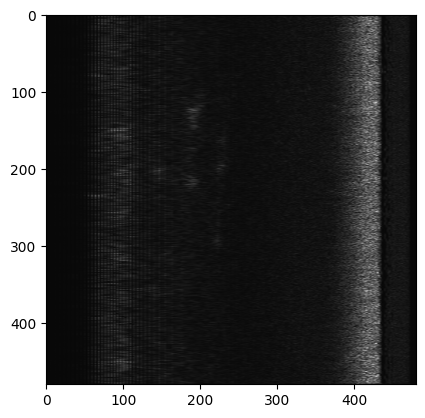

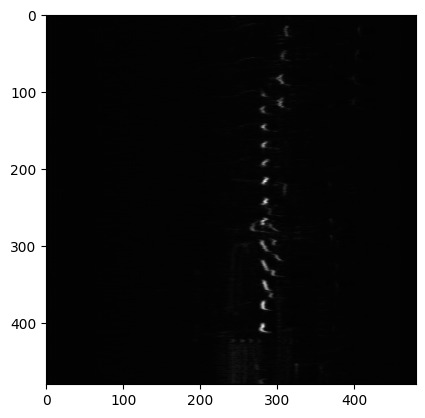

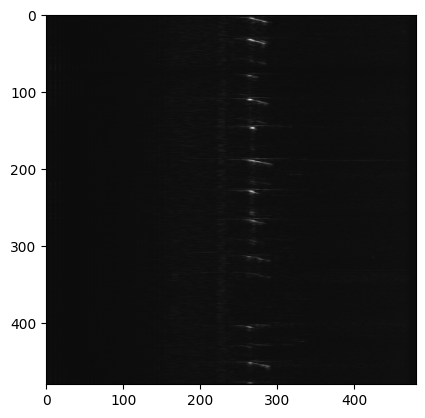

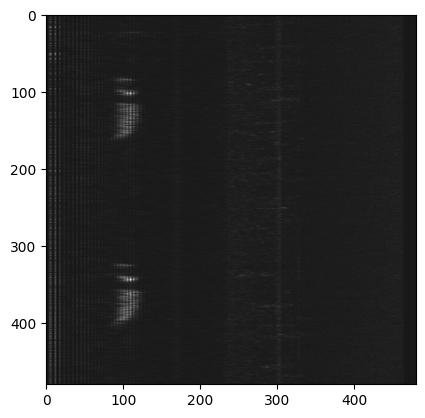

In [ ]:
# show what the pipeline looks like at this stage
for melspectrogram,label in train_dataset.take(1):
    print(f' sample info: {melspectrogram.shape}, {label}')
    plt.imshow(melspectrogram[0,:,:,:], cmap='afmhot')
    plt.show()
    plt.imshow(melspectrogram[2,:,:,:], cmap='afmhot')
    plt.show()
    plt.imshow(melspectrogram[3,:,:,:], cmap='afmhot')
    plt.show()
    plt.imshow(melspectrogram[4,:,:,:], cmap='afmhot')
    plt.show()

In [ ]:
def build_model(trainable):
    # build a really simple classification model using a pre-training Efficientnet V2
    model = tf.keras.Sequential(
        [
            # input layer
            tf.keras.layers.InputLayer(input_shape=(MODEL_INPUT_IMAGE_HEIGHT, MODEL_INPUT_IMAGE_WIDTH,3)),
  
            # use the model as a feature generator only
            hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2", trainable), 
                     
            # add the classification layer here       
            tf.keras.layers.Flatten(), 
            tf.keras.layers.BatchNormalization(),
            
            tf.keras.layers.Dense(len(class_names)*3, activation="relu", kernel_regularizer=tf.keras.regularizers.L1(1e-2)),
            tf.keras.layers.BatchNormalization(),
            
            tf.keras.layers.Dense(len(class_names)*2, activation="relu", kernel_regularizer=tf.keras.regularizers.L1(1e-2)),
            tf.keras.layers.BatchNormalization(),
            
            tf.keras.layers.Dropout(0.50),
            tf.keras.layers.Dense(len(class_names)*1, activation=None),
        ]
    )
    # need to tell the model what the input shape is
    model.build([None, 
                 MODEL_INPUT_IMAGE_HEIGHT,
                 MODEL_INPUT_IMAGE_WIDTH, 
                 MODEL_INPUT_IMAGE_CHANNELS])

    # show the model
    model.summary()
    
    return model

In [ ]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
# allow all the weights to be trained
model = build_model(True)

# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), 
              metrics=["accuracy"],
              )

# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                      factor=0.75,
                                                      patience=20, 
                                                      verbose=1,
                                                      mode='min',
                                                      cooldown=0, 
                                                      min_lr=1e-8)

# end the training if no improvement for 16 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_generic_model.hdf5', 
                                           save_best_only=True, 
                                           monitor='val_loss', 
                                           mode='min')

# fit the model to the training set
model.fit(train_dataset, 
          validation_data=validation_dataset,
          callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
          epochs=1000)      

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              53150388  
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
 batch_normalization_1 (Batc  (None, 15)               60        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)                1

In [ ]:
# save the model weights
model.save_weights('models/baseline_cnn_model.hdf5', save_format='h5')

# test load the model for inference
test_model = build_model(False)
test_model.build([None, 
                MODEL_INPUT_IMAGE_HEIGHT,
                MODEL_INPUT_IMAGE_WIDTH, 
                MODEL_INPUT_IMAGE_CHANNELS])
test_model.load_weights('models/baseline_cnn_model.hdf5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              53150388  
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 batch_normalization_3 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 15)                19215     
                                                                 
 batch_normalization_4 (Batc  (None, 15)               60        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)               